In [24]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import json
from tqdm import tqdm
from sklearn.metrics import average_precision_score

In [25]:
sl_path = '/home/jasonclarke/H-drive/mnt/parscratch/users/acp21jrc/sl_ASD_github/outputs/pyannote_MD-0.0_visible/'
light_path = '/home/jasonclarke/H-drive/users/acp21jrc/Light-ASD_Ego4D/output/results/'
# light_path = '/home/jasonclarke/H-drive/mnt/parscratch/users/acp21jrc/audio-visual/active-speaker-detection/active_speaker/TalkNet_ASD/Ego4d_TalkNet_ASD/output/results'

# collect all the json files
json_files_light = {f.split('/')[-1].split('.')[0]: f for f in glob(light_path + '/*.json')}

# find all the json files that are not in the sl path
json_files_sl = {f.split('/')[-1].split('.')[0]: f for f in glob(sl_path + '/*.json')}

# if trackid in json_files_sl then use json_files_sl[trackid]
all_file_paths = []
for trackid in json_files_light.keys():
    if trackid in json_files_sl:
        all_file_paths.append(json_files_sl[trackid])
    else:
        all_file_paths.append(json_files_light[trackid])


all_scores = []
all_labels = []
for f in tqdm(all_file_paths):
    with open(f) as json_file:
        data = json.load(json_file)
        for frame in data:
            all_scores.append(float(frame['score']))
            if 'label' in frame:
                label = frame['label']
            else:
                label = frame['activity']
            all_labels.append(label)

average_precision_score(all_labels, all_scores)

  0%|          | 0/4068 [00:00<?, ?it/s]

100%|██████████| 4068/4068 [07:20<00:00,  9.24it/s]


np.float64(0.5570521870340842)

In [4]:
import numpy as np
from sklearn.metrics import average_precision_score

# Initialize arrays with efficient datatypes
scores = np.array([], dtype=np.float32)  # Halves memory usage vs float64
labels = np.array([], dtype=np.uint8)    # 8x more efficient than float64
n_sl = 0
for j, trackid in tqdm(enumerate(json_files_light)):
    with open(json_files_light[trackid]) as f:
        light_data = json.load(f)

    if trackid in json_files_sl:
        n_sl += 1
        with open(json_files_sl[trackid]) as f:
            sl_data = json.load(f)
        
        assert len(sl_data) == len(light_data), f"Length mismatch for {trackid}"

        # Preallocate temporary arrays
        track_scores = np.zeros(len(light_data), dtype=np.float32)
        track_labels = np.zeros(len(light_data), dtype=np.uint8)

        for i, (frame_light, frame_sl) in enumerate(zip(light_data, sl_data)):
            # track_scores[i] = (float(frame_light['score']) + float(frame_sl['score'])) / 2
            # track_scores[i] = float(frame_sl['score'])  # Use only sl score
            track_scores[i] = float(frame_light['score']) # use only light score
            track_labels[i] = int(round(frame_light['label']))  # Ensure binary labels

        scores = np.concatenate([scores, track_scores])
        labels = np.concatenate([labels, track_labels])
    else:
        track_scores = np.zeros(len(light_data), dtype=np.float32)
        track_labels = np.zeros(len(light_data), dtype=np.uint8)

        for i, frame_light in enumerate(light_data):
            track_scores[i] = float(frame_light['score'])
            track_labels[i] = int(round(frame_light['label']))

        scores = np.concatenate([scores, track_scores])
        labels = np.concatenate([labels, track_labels])

ap_score = average_precision_score(labels, scores)
print(ap_score)
print('proportion of tracks processed by sl: ', n_sl / j)

4068it [10:36,  6.39it/s]


1.0
proportion of tracks processed by sl:  0.540447504302926


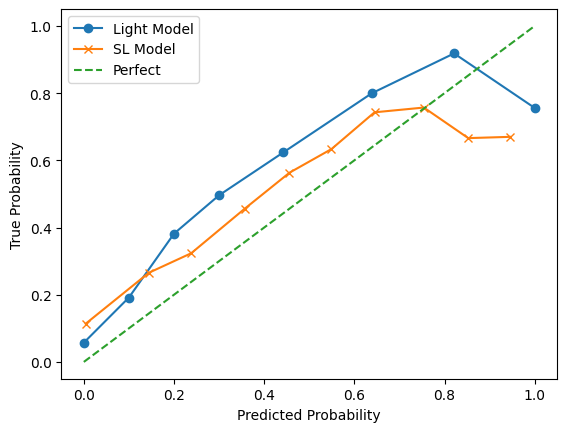

In [4]:
from sklearn.calibration import calibration_curve

# For Model 1 (light_data)
prob_true_light, prob_pred_light = calibration_curve(labs, light_scores, n_bins=10)

# For Model 2 (sl_data)
prob_true_sl, prob_pred_sl = calibration_curve(labs, sl_scores, n_bins=10)

plt.plot(prob_pred_light, prob_true_light, marker='o', label='Light Model')
plt.plot(prob_pred_sl, prob_true_sl, marker='x', label='SL Model')
plt.plot([0,1], [0,1], linestyle='--', label='Perfect')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.legend()

(array([2.400e+01, 2.280e+02, 9.030e+02, 1.719e+03, 2.017e+03, 1.904e+03,
        1.547e+03, 2.420e+03, 9.190e+02, 8.160e+02, 6.550e+02, 6.270e+02,
        6.310e+02, 5.900e+02, 8.980e+02, 3.310e+02, 3.070e+02, 2.970e+02,
        2.210e+02, 2.100e+02, 2.290e+02, 3.600e+02, 1.580e+02, 1.330e+02,
        1.440e+02, 1.040e+02, 1.080e+02, 8.600e+01, 1.450e+02, 6.200e+01,
        5.000e+01, 4.900e+01, 2.800e+01, 2.400e+01, 2.000e+01, 3.600e+01,
        5.000e+00, 5.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 4.000e+00,
        8.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 3.000e+00,
        3.000e+00, 1.000e+00]),
 array([-5.        , -4.886     , -4.772     , -4.658     , -4.544     ,
        -4.43      , -4.316     , -4.202     , -4.088     , -3.974     ,
        -3.86      , -3.746     , -3.632     , -3.518     , -3.404     ,
        -3.29      , -3.176     , -3.062     , -2.948     , -2.834     ,
        -2.72      , -2.60600001, -2.49200001, -2.37800001, -2.26400001,
        -2.

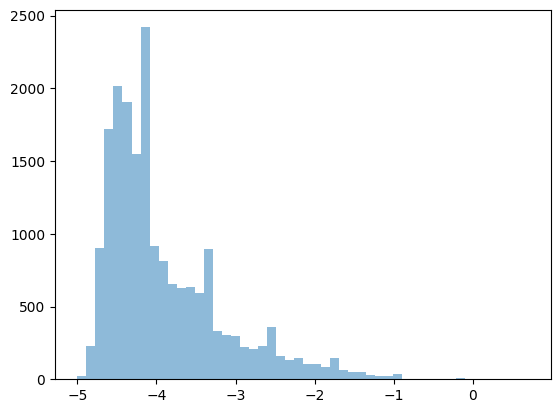

In [5]:
# plot histogram of scores
plt.figure()
plt.hist(light_scores, bins=50, alpha=0.5, label='Light Model')

In [9]:
from tqdm import tqdm

path = '/home/jasonclarke/H-drive/users/acp21jrc/audio-visual/active-speaker-detection/active_speaker/TalkNet_ASD/Ego4d_TalkNet_ASD/output/results/'
all_files = glob(path + '/*.json')
all_scores = []
all_labels = []

for f in tqdm(all_files[:1000]):
    with open(f) as json_file:
        data = json.load(json_file)
        for frame in data:
            all_scores.append(float(frame['score']))
            all_labels.append(int(round(frame['label'])))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:29<00:00, 11.14it/s]


In [10]:
average_precision_score(all_labels, all_scores)

np.float64(0.4348108604806008)